In [141]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("data/ligand-qsar/alkylamine-ligand-modeling.tsv", sep="\t")
df = df[df["buchwald-type"] > 0]

# Define bins and labels
activity_cutoff = 15
bins = [-np.inf, activity_cutoff, np.inf]
labels = ["Low", "High"]
transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={"bins": bins, "labels": labels, "retbins": False})

features = [
    "buried_volume_2.0A",
    "P_int_ipso_carbon",
    "min_distance_avg_amine_N_H",
    "min_partial_charge_phosphine",
    "max_buried_volume_3.5A",
    "max_P_int_ligand",
    "max_sasa_ligand_area",
    "max_partial_charge_phosphine",
    "max_fukui_f_zero_ipso_carbon",
]

# Standardize features
scaler = StandardScaler()
X = df.drop(columns=["ligand_1_name", "product_1_yield"])[features]
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Transform target
y = df["product_1_yield"]
y_bin = transformer.fit_transform(y)

In [142]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


def evaluate_model(clf):
    """Evaluate a model using cross-validation."""
    clf.fit(X, y_bin)
    preds = clf.predict(X)
    print(f"Accuracy: {metrics.accuracy_score(y_bin, preds):0.2f}")
    print(f"F1: {metrics.f1_score(y_bin, preds, pos_label='High'):0.2f}")
    print(f"MCC: {metrics.matthews_corrcoef(y_bin, preds):0.2f}")
    print("Confusion matrix:\n", metrics.confusion_matrix(y_bin, preds))
    print(f"Incorrect ligands: {df.loc[y_bin != preds, 'ligand_1_name'].tolist()}")
    print()

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    kfold_accuracies = []
    kfold_high_yield_f1s = []
    kfold_mccs = []
    for train_index, test_index in kfold.split(X, y_bin):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_bin[train_index], y_bin[test_index]

        clf
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        accuracy = metrics.accuracy_score(y_test, preds)
        high_yield_f1 = metrics.f1_score(y_test, preds, pos_label="High")
        mcc = metrics.matthews_corrcoef(y_test, preds)

        kfold_accuracies.append(accuracy)
        kfold_high_yield_f1s.append(high_yield_f1)
        kfold_mccs.append(mcc)

    print(f"K-Fold Accuracy: {np.mean(kfold_accuracies):0.2f} +/- {np.std(kfold_accuracies):0.2f}")
    print(f"K-Fold F1: {np.mean(kfold_high_yield_f1s):0.2f} +/- {np.std(kfold_high_yield_f1s):0.2f}")
    print(f"K-Fold MCC: {np.mean(kfold_mccs):0.2f} +/- {np.std(kfold_mccs):0.2f}")
    print()

Accuracy: 0.98
F1: 0.88
MCC: 0.87
Confusion matrix:
 [[ 7  0]
 [ 2 85]]
Incorrect ligands: ['L-108', 'L-128']

K-Fold Accuracy: 0.95 +/- 0.05
K-Fold F1: 0.68 +/- 0.21
K-Fold MCC: 0.68 +/- 0.23



[Text(0.4, 0.8333333333333334, 'max_sasa_ligand_area <= 0.908\ngini = 0.5\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass = Low'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 86.2%\nvalue = [0.0, 1.0]\nclass = High'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'max_partial_charge_phosphine <= -0.131\ngini = 0.121\nsamples = 13.8%\nvalue = [0.935, 0.065]\nclass = Low'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 4.3%\nvalue = [0.0, 1.0]\nclass = High'),
 Text(0.8, 0.16666666666666666, 'gini = 0.044\nsamples = 9.6%\nvalue = [0.978, 0.022]\nclass = Low')]

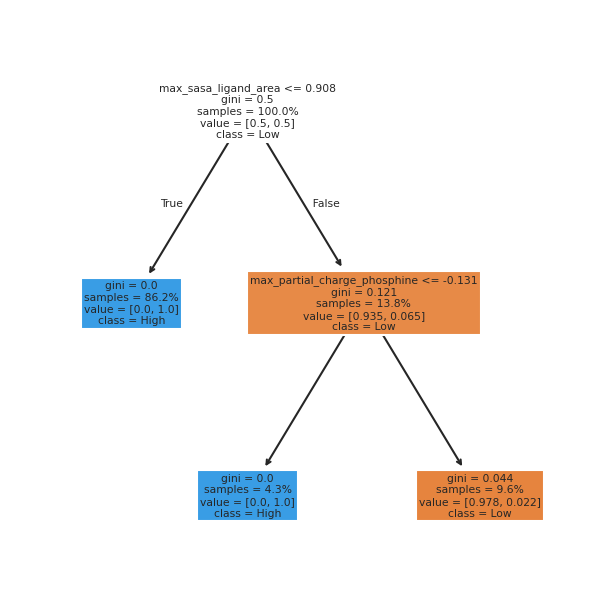

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)

clf = DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=42)
evaluate_model(clf)
clf.fit(X, y_bin)

plot_tree(clf, feature_names=X.columns, class_names=labels, filled=True, proportion=True)

Feature 0: max_sasa_ligand_area, threshold: 0.9081305265426636
Feature 1: max_partial_charge_phosphine, threshold: -0.13071686029434204


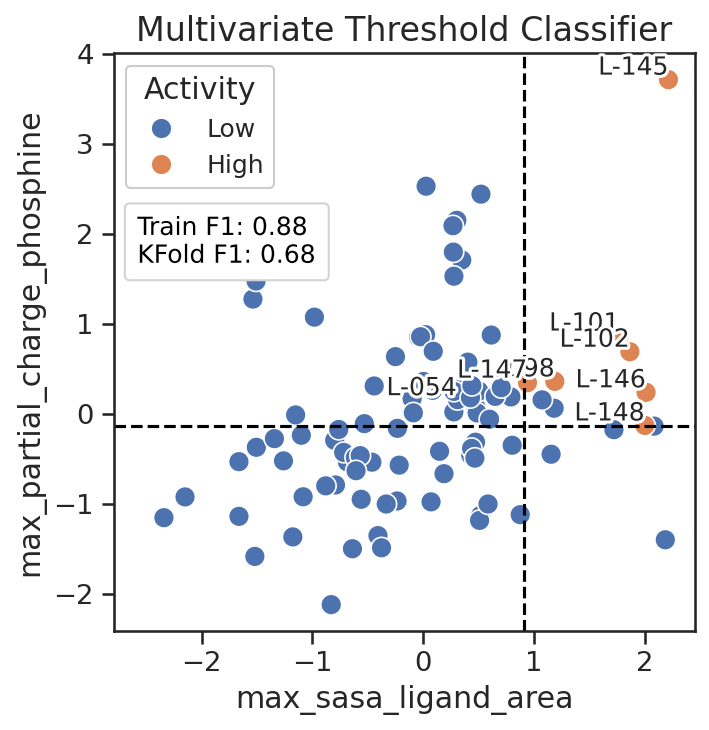

In [144]:
import seaborn as sns
from matplotlib import patheffects as pe
from matplotlib import pyplot as plt

feature_0 = X.columns[clf.tree_.feature[0]]
feature_1 = X.columns[clf.tree_.feature[2]]

feature_0_threshold = clf.tree_.threshold[0]
feature_1_threshold = clf.tree_.threshold[2]

print(f"Feature 0: {feature_0}, threshold: {feature_0_threshold}")
print(f"Feature 1: {feature_1}, threshold: {feature_1_threshold}")

ax = sns.scatterplot(data=X, x=feature_0, y=feature_1, hue=y_bin, s=100)

ax.axvline(feature_0_threshold, color="black", linestyle="--")
ax.axhline(feature_1_threshold, color="black", linestyle="--")

for i, txt in enumerate(df["ligand_1_name"]):
    if y_bin[i] == "High":
        ax.annotate(
            txt,
            (X[feature_0].values[i], X[feature_1].values[i]),
            fontsize=12,
            ha="right",
            va="bottom",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        )
    if txt == "L-054":
        ax.annotate(
            txt,
            (X[feature_0].values[i], X[feature_1].values[i]),
            fontsize=12,
            ha="right",
            va="bottom",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        )

legend = ax.legend(title="Activity", loc="upper left", fontsize=12, framealpha=1.0)

f1 = metrics.f1_score(y_bin, clf.predict(X), pos_label="High")

ax.text(
    -2.58,
    2.2,
    f"Train F1: {f1:.2f}\nKFold F1: 0.68",
    fontsize=12,
    color="black",
    ha="left",
    va="top",
    bbox=dict(
        facecolor="white",
        alpha=1.0,
        edgecolor="lightgrey",
        boxstyle="round,pad=0.5,rounding_size=0.2",
    ),
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
)

ax.set_title("Multivariate Threshold Classifier", fontsize=16)

plt.show()